In [1]:
# Changes to make: 
# Bring back outliers for delivery handover (at least 30 min) 
# Median hexagon handover instead of log 

# Problem Statement

NB: While this use case is loosely based on my work experience, I prepared mock data with the help of AI, and the approach is chosen based on this data.

#### Context: 
I work as a Data Analyst in a food delivery company. For smooth logistics we need to make sure our predictions are as accurate as possible: as we assign orders to couriers in real time, we need to estimate when each courier finishes their last delivery to make sure customer's waiting time is as low as possible. Currently we have a problem with estimating last leg of delivery, which is time period between courier's arrival to location and the moment when they press "delivered" (aka "Delivery Handover Time"). Let's assume that currently we simply estimate city's average for each order, we want to improve this estimate. 

#### Objective: 
Predict the Delivery Handover Time for each order based on order, courier, and delivery characteristics.

#### Type of Problem: 
Regression — the target variable delivery_handover_min is continuous.

##### Potential Modeling Steps:
Exploratory data analysis (EDA): Check distributions, correlations, and outliers, especially in delivery_handover_min.

Feature engineering: Extract weekday/month from orderday, encode categorical variables (vehicle_type).

Modeling: Linear regression, tree-based models (RandomForest, XGBoost), or ensemble methods.

Evaluation: Use metrics like RMSE, MAE, or R² to measure prediction accuracy.

## Data Preparation

In [2]:
# all imports are added here 

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [3]:
df = pd.read_csv('mock_handover_data_nonlinear.csv')

In [4]:
df.head()

,orderday,order_id,delivery_deviation,median_delivery_handover_min_same_location,vehicle_type,is_pooled,has_alcohol,is_new_courier,is_large_order,delivery_handover_min
0,2025-11-26,221958,2.24,2.4858,BIKE,0,0,0,0,3.25
1,2025-10-24,771155,3.49,3.9251,CAR,0,0,0,0,4.63
2,2025-10-17,231932,3.42,2.3434,CAR,0,0,0,0,2.77
3,2025-10-27,465838,3.72,3.0453,BIKE,0,0,1,0,6.32
4,2025-11-09,359178,5.83,3.9538,MOPED,0,0,1,0,8.21


In [5]:
# !!! Replace later 
df['median_delivery_handover_min_same_location'] = np.expm1(df.avg_delivery_handover_min_same_location)
df['order_id'] = np.random.randint(100000, 999999, size=len(df))

In [5]:
# the data set was already cleaned up during its preparation but we want to make sure there are no nulls 
df.isnull().sum()

orderday                                      0
order_id                                      0
delivery_deviation                            0
median_delivery_handover_min_same_location    0
vehicle_type                                  0
is_pooled                                     0
has_alcohol                                   0
is_new_courier                                0
is_large_order                                0
delivery_handover_min                         0
dtype: int64

In [6]:
df.describe()

,order_id,delivery_deviation,median_delivery_handover_min_same_location,is_pooled,has_alcohol,is_new_courier,is_large_order,delivery_handover_min
count,9655.000000,9655.000000,9655.000000,9655.000000,9655.000000,9655.000000,9655.000000,9655.000000
mean,553870.304298,4.338161,3.682280,0.297255,0.046504,0.392957,0.094252,7.590208
std,259509.183895,2.028349,1.425588,0.457074,0.210586,0.488433,0.292194,4.475679
min,100126.000000,0.530000,0.513100,0.000000,0.000000,0.000000,0.000000,0.650000
25%,330080.000000,2.830000,2.657800,0.000000,0.000000,0.000000,0.000000,4.390000
50%,554179.000000,3.960000,3.478100,0.000000,0.000000,0.000000,0.000000,6.430000
75%,780009.500000,5.480000,4.487250,1.000000,0.000000,1.000000,0.000000,9.500000
max,999885.000000,14.460000,12.548000,1.000000,1.000000,1.000000,1.000000,24.970000


##### Target Variable: 
delivery_handover_min: actual delivery handover time in mins per order, the value we want to predict

##### Numeric Variables: 
delivery_deviation: absolute deviation from ETA (expected time of arrival); we expect that high deviation causes longer handover (a customer does not expect the order)

median_delivery_handover_min_same_location: median handover time in the same customer location (using hexagons). If a customer orders to a tall building or office area we can expect higher handover time. We do not have a better metric unfortunately, so instead of using ID for each hexagon (which is computationally heavy) we can use a median as an estimate

##### Categotical Variable: 
vehicle_type: cars can take longer time to park; can be changed to a binary variable as well 

##### Binary Variables: 
is_pooled: a courier can have several orders in a bag. We expect that if there are still some orders in the bag a courier will hand over the order quicker. 

has_alcohol: a courier might need to validate ID

is_new_courier: it is more difficult for new couriers to find exact location or contact help desk or customer. 

is_large_order: large orders can take more time to deliver

## EDA

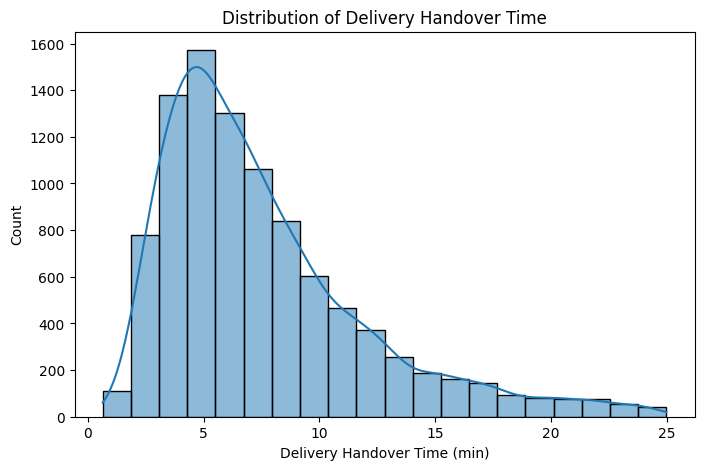

In [8]:
plt.figure(figsize=(8,5))
sns.histplot(df['delivery_handover_min'], kde=True, bins=20)
plt.title('Distribution of Delivery Handover Time')
plt.xlabel('Delivery Handover Time (min)')
plt.ylabel('Count')
plt.show()

# The metric is right-skewed, with outliers > 25 min obviously filtered out 
# Log transformation would be useful here 

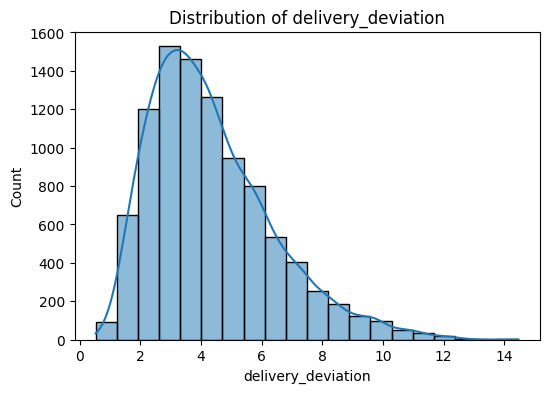

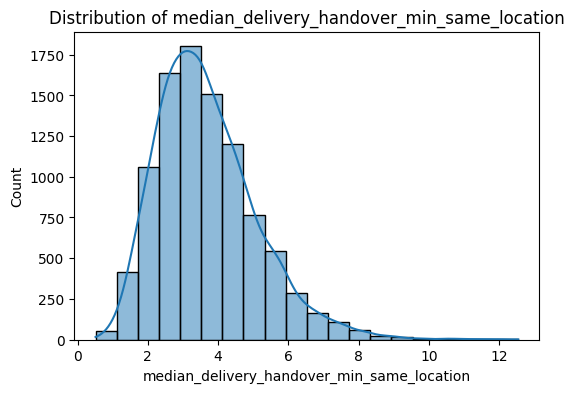

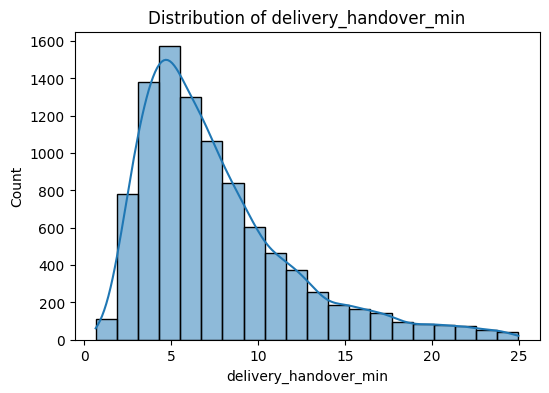

In [9]:
numeric_cols = ['delivery_deviation', 'median_delivery_handover_min_same_location', 'delivery_handover_min']

for col in numeric_cols:
    plt.figure(figsize=(6,4))
    sns.histplot(df[col], kde=True, bins=20)
    plt.title(f'Distribution of {col}')
    plt.show()

# both are right-skewed as well, log transformation might help a bit 

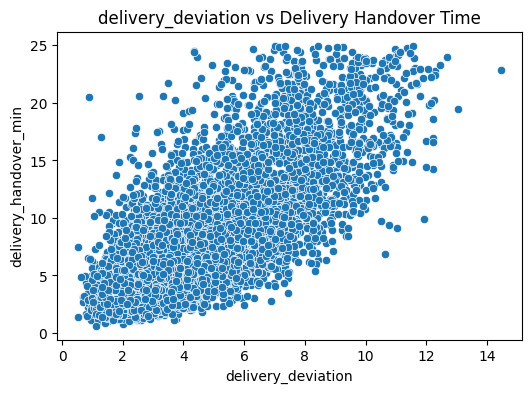

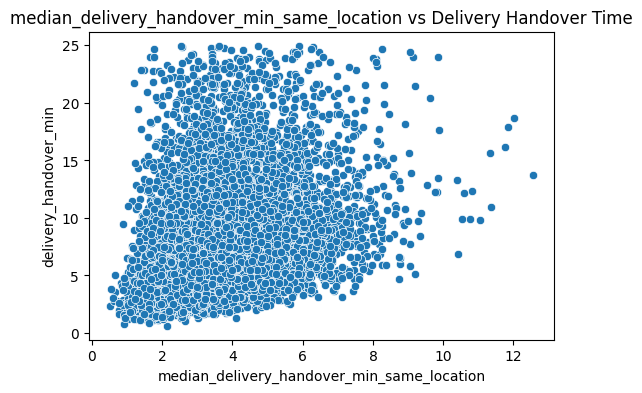

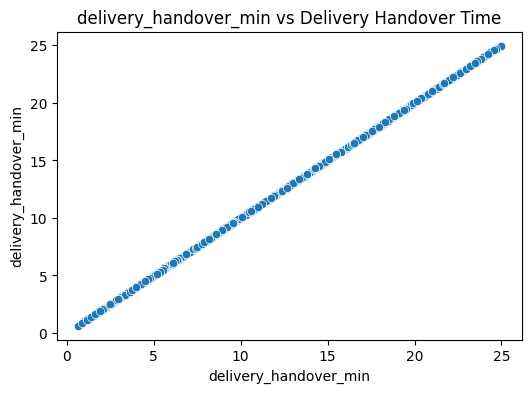

In [10]:
for col in numeric_cols:
    plt.figure(figsize=(6,4))
    sns.scatterplot(x=df[col], y=df['delivery_handover_min'])
    plt.title(f'{col} vs Delivery Handover Time')
    plt.show()

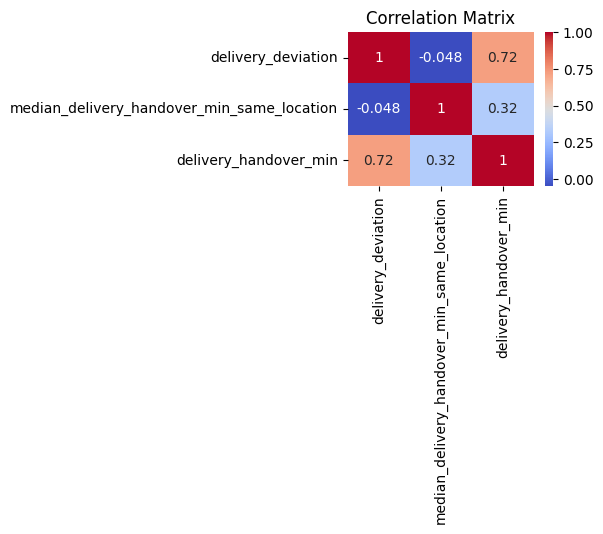

In [11]:
plt.figure(figsize=(3,2))
sns.heatmap(df[numeric_cols].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

# Delivery Deviation has surprisingly high correlation with Delivery Handover while Median Handover Time much lower

In [12]:
categorical_cols = ['vehicle_type', 'is_pooled', 'has_alcohol', 'is_new_courier', 'is_large_order']

In [13]:
global_delivery_handover = df.delivery_handover_min.mean()
for c in categorical_cols:
    df_group = df.groupby(c).delivery_handover_min.agg(["mean", "count"])
    df_group["percent"] = (df_group["count"] / len(df)).round(4)*100
    df_group["diff"] = df_group["mean"] - global_delivery_handover
    df_group["risk"] = df_group["mean"] / global_delivery_handover
    display(df_group)

# vehicle type, alcohol and large order seem to make a difference 

,mean,count,percent,diff,risk
vehicle_type,,,,,
BIKE,7.273512,5871,60.81,-0.316696,0.958276
CAR,8.348372,2794,28.94,0.758163,1.099887
MOPED,7.328606,990,10.25,-0.261602,0.965534


,mean,count,percent,diff,risk
is_pooled,,,,,
0,7.418952,6785,70.27,-0.171256,0.977437
1,7.995077,2870,29.73,0.404868,1.053341


,mean,count,percent,diff,risk
has_alcohol,,,,,
0,7.507259,9206,95.35,-0.082949,0.989072
1,9.290935,449,4.65,1.700727,1.224069


,mean,count,percent,diff,risk
is_new_courier,,,,,
0,6.660950,5861,60.7,-0.929258,0.877571
1,9.025733,3794,39.3,1.435525,1.189128


,mean,count,percent,diff,risk
is_large_order,,,,,
0,7.496810,8745,90.57,-0.093399,0.987695
1,8.487758,910,9.43,0.897550,1.118251


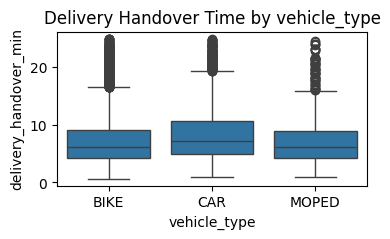

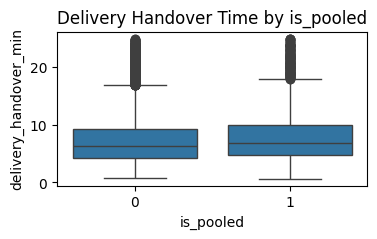

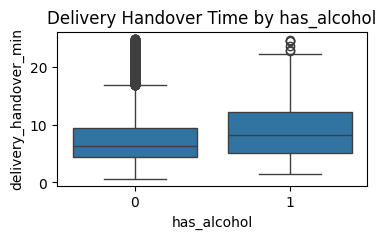

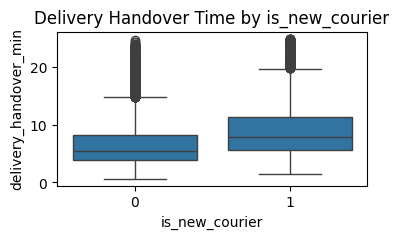

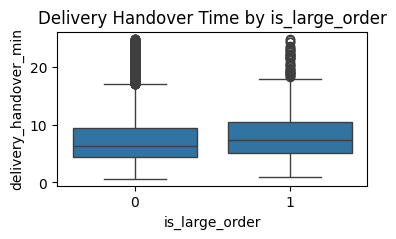

In [14]:
for col in categorical_cols:
    plt.figure(figsize=(4,2))
    sns.boxplot(x=df[col], y=df['delivery_handover_min'])
    plt.title(f'Delivery Handover Time by {col}')
    plt.show()

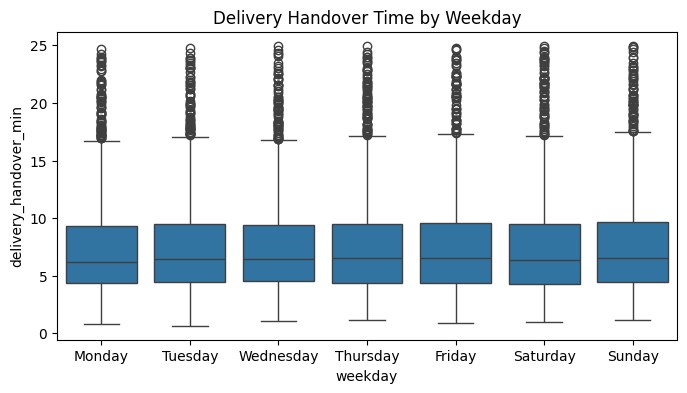

In [15]:
# Weekday check 

df['orderday'] = pd.to_datetime(df['orderday'])
df['weekday'] = df['orderday'].dt.day_name()

# Boxplot by weekday
plt.figure(figsize=(8,4))
sns.boxplot(x='weekday', y='delivery_handover_min', data=df, order=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])
plt.title('Delivery Handover Time by Weekday')
plt.show()

# No visible difference 

## Model Training

In [16]:
# We checked previously that model can benefit from log transformation of numeric columns 
# Create log-transformed columns
for col in numeric_cols:
    df[f"log_{col}"] = np.log1p(df[col])  # log1p handles zeros safely

In [17]:
# Let's compare two very simple models, one log transformed and another not 

# Model A inputs (raw features)
X_raw = df[[
    "delivery_deviation",
    "median_delivery_handover_min_same_location"
]]

y_raw = df["delivery_handover_min"]

# Model B inputs (log features)
X_log = df[[
    "log_delivery_deviation",
    "log_median_delivery_handover_min_same_location"
]]

y_log = df["log_delivery_handover_min"]

# Split
X_raw_train, X_raw_test, y_raw_train, y_raw_test = train_test_split(
    X_raw, y_raw, test_size=0.2, random_state=42
)

X_log_train, X_log_test, y_log_train, y_log_test = train_test_split(
    X_log, y_log, test_size=0.2, random_state=42
)

# FIT TWO SIMPLE LINEAR REGRESSION MODELS

# Model A (raw)
lr_raw = LinearRegression()
lr_raw.fit(X_raw_train, y_raw_train)

# Model B (log-transformed)
lr_log = LinearRegression()
lr_log.fit(X_log_train, y_log_train)

# Model C (only target log-transformed)
lr_logt = LinearRegression()
lr_logt.fit(X_raw_train, y_log_train)

# EVALUATE MODELS

# Predictions
y_pred_raw = lr_raw.predict(X_raw_test)
y_pred_log = lr_log.predict(X_log_test)
y_pred_logt = lr_logt.predict(X_raw_test)

# Convert log-predictions back to actual minutes
y_pred_log_inverse = np.expm1(y_pred_log)
y_pred_logt_inverse = np.expm1(y_pred_logt)

# RMSE for raw model
rmse_raw = np.sqrt(mean_squared_error(y_raw_test, y_pred_raw))

# RMSE for log model (compare in original units)
rmse_log = np.sqrt(mean_squared_error(y_raw_test, y_pred_log_inverse))

rmse_logt = np.sqrt(mean_squared_error(y_raw_test, y_pred_logt_inverse))


r2_raw = r2_score(y_raw_test, y_pred_raw)
r2_log = r2_score(y_raw_test, y_pred_log_inverse)
r2_logt = r2_score(y_raw_test, y_pred_logt_inverse)


print("RMSE — Raw Linear Regression:", rmse_raw)
print("RMSE — Log-Transformed Linear Regression:", rmse_log)
print("RMSE — Log-Transformed (Only Target) Linear Regression:", rmse_logt)


print("R2 — Raw Linear Regression:", r2_raw)
print("R2 — Log-Transformed Linear Regression:", r2_log)
print("R2 — Log-Transformed (Only Target) Linear Regression:", r2_logt)

RMSE — Raw Linear Regression: 2.7226329804740432
RMSE — Log-Transformed Linear Regression: 2.7928664524067988
RMSE — Log-Transformed (Only Target) Linear Regression: 2.7041134327537337
R2 — Raw Linear Regression: 0.6352559730704082
R2 — Log-Transformed Linear Regression: 0.6161952676812505
R2 — Log-Transformed (Only Target) Linear Regression: 0.6402011278664828


In [18]:
# Log transformation didn't help a lot, so we will keep the metrics as is, especially as we'll be using other models that can deal with it

In [19]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score

In [20]:
# Target
y = df["delivery_handover_min"]

# Feature columns
features = [
    "delivery_deviation",
    "median_delivery_handover_min_same_location",
    "vehicle_type",
    "is_pooled",
    "has_alcohol",
    "is_new_courier",
    "is_large_order"
]

X = df[features]

In [21]:
# First split: Train + Val vs Test (80/20)
X_fulltrain, X_test, y_fulltrain, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Second split: Train vs Val (60/20)
X_train, X_val, y_train, y_val = train_test_split(
    X_fulltrain, y_fulltrain, test_size=0.25, random_state=42
)

In [22]:
categorical = ["vehicle_type"]
numeric = [
    "delivery_deviation",
    "median_delivery_handover_min_same_location"
]

binary = [
    "is_pooled",
    "has_alcohol",
    "is_new_courier",
    "is_large_order"
]

preprocess = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical),
        ("num", "passthrough", numeric), 
        ("bin", "passthrough", binary)
    ]
)

In [23]:
lr_pipeline = Pipeline([
    ("preprocess", preprocess),
    ("model", LinearRegression())
])

lr_pipeline.fit(X_train, y_train)

,steps,"[('preprocess', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('cat', ...), ('num', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [24]:
ridge_pipeline = Pipeline([
    ("preprocess", preprocess),
    ("model", Ridge())
])

ridge_params = {
    "model__alpha": [0.1, 1.0, 10.0, 50.0]
}

ridge_gs = GridSearchCV(ridge_pipeline, ridge_params, cv=5, scoring="neg_root_mean_squared_error")
ridge_gs.fit(X_train, y_train)

,estimator,"Pipeline(step...l', Ridge())])"
,param_grid,"{'model__alpha': [0.1, 1.0, ...]}"
,scoring,'neg_root_mean_squared_error'
,n_jobs,None
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,transformers,"[('cat', ...), ('num', ...), ...]"


In [25]:
lasso_pipeline = Pipeline([
    ("preprocess", preprocess),
    ("model", Lasso(max_iter=5000))
])

lasso_params = {
    "model__alpha": [0.001, 0.01, 0.1, 1.0]
}

lasso_gs = GridSearchCV(lasso_pipeline, lasso_params, cv=5, scoring="neg_root_mean_squared_error")
lasso_gs.fit(X_train, y_train)


,estimator,Pipeline(step..._iter=5000))])
,param_grid,"{'model__alpha': [0.001, 0.01, ...]}"
,scoring,'neg_root_mean_squared_error'
,n_jobs,None
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,transformers,"[('cat', ...), ('num', ...), ...]"


In [26]:
rf_pipeline = Pipeline([
    ("preprocess", preprocess),
    ("model", RandomForestRegressor(random_state=42))
])

rf_params = {
    "model__n_estimators": [150, 300],
    "model__max_depth": [5, 10, None],
    "model__min_samples_split": [2, 5]
}

rf_gs = GridSearchCV(rf_pipeline, rf_params, cv=3, scoring="neg_root_mean_squared_error", n_jobs=-1)
rf_gs.fit(X_train, y_train)

,estimator,Pipeline(step...m_state=42))])
,param_grid,"{'model__max_depth': [5, 10, ...], 'model__min_samples_split': [2, 5], 'model__n_estimators': [150, 300]}"
,scoring,'neg_root_mean_squared_error'
,n_jobs,-1
,refit,True
,cv,3
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,transformers,"[('cat', ...), ('num', ...), ...]"


In [27]:
xgb_pipeline = Pipeline([
    ("preprocess", preprocess),
    ("model", XGBRegressor(
        objective="reg:squarederror",
        random_state=42,
        eval_metric="rmse"
    ))
])

xgb_params = {
    "model__n_estimators": [200, 300],
    "model__max_depth": [3, 5],
    "model__learning_rate": [0.05, 0.1],
    "model__subsample": [0.8, 1.0]
}

xgb_gs = GridSearchCV(xgb_pipeline, xgb_params, cv=3, scoring="neg_root_mean_squared_error", n_jobs=-1)
xgb_gs.fit(X_train, y_train)

,estimator,"Pipeline(step...=None, ...))])"
,param_grid,"{'model__learning_rate': [0.05, 0.1], 'model__max_depth': [3, 5], 'model__n_estimators': [200, 300], 'model__subsample': [0.8, 1.0]}"
,scoring,'neg_root_mean_squared_error'
,n_jobs,-1
,refit,True
,cv,3
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,transformers,"[('cat', ...), ('num', ...), ...]"


In [28]:
def evaluate(model, X, y):
    pred = model.predict(X)
    return {
        "RMSE": root_mean_squared_error(y, pred),
        "MAE": mean_absolute_error(y, pred),
        "R2": r2_score(y, pred)
    }

In [29]:
results = {
    "Linear Regression": evaluate(lr_pipeline, X_val, y_val),
    "Ridge": evaluate(ridge_gs.best_estimator_, X_val, y_val),
    "Lasso": evaluate(lasso_gs.best_estimator_, X_val, y_val),
    "Random Forest": evaluate(rf_gs.best_estimator_, X_val, y_val),
    "XGBoost": evaluate(xgb_gs.best_estimator_, X_val, y_val),
}

pd.DataFrame(results).T

,RMSE,MAE,R2
Linear Regression,2.209298,1.637050,0.765800
Ridge,2.209473,1.636978,0.765762
Lasso,2.209838,1.636886,0.765685
Random Forest,2.097775,1.495720,0.788847
XGBoost,1.925084,1.413215,0.822181


In [30]:
xgb_gs.best_params_

{'model__learning_rate': 0.05,
 'model__max_depth': 3,
 'model__n_estimators': 300,
 'model__subsample': 1.0}

#### XGBoost performs the best, we will use it for final prediction on test set

In [ ]:
final_model = xgb_gs.best_estimator_
evaluate(final_model, X_test, y_test)

In [33]:
ohe = final_model.named_steps["preprocess"].named_transformers_["cat"]
cat_names = ohe.get_feature_names_out(["vehicle_type"])
feature_names = list(cat_names) + numeric + binary

In [34]:
importances = final_model.named_steps["model"].feature_importances_
fi = pd.DataFrame({"feature": feature_names, "importance": importances})
fi.sort_values("importance", ascending=False)

,feature,importance
3,delivery_deviation,0.377136
7,is_new_courier,0.236103
6,has_alcohol,0.139951
4,median_delivery_handover_min_same_location,0.103915
1,vehicle_type_CAR,0.069190
8,is_large_order,0.040580
5,is_pooled,0.023887
0,vehicle_type_BIKE,0.005286
2,vehicle_type_MOPED,0.003953


In [35]:
import pickle

In [51]:
# saving the model we've created to a file
with open('model.bin', 'wb') as f_out:
    pickle.dump(xgb_gs, f_out)

In [52]:
# loading the file with a model
with open('model.bin', 'rb') as f_in:
    pipeline = pickle.load(f_in)

In [63]:
order = {
 'orderday': '2025-10-21 00:00:00',
 'order_id': 314283,
 'delivery_deviation': 3.42,
 'median_delivery_handover_min_same_location': 5.6495,
 'vehicle_type': 'CAR',
 'is_pooled': 0,
 'has_alcohol': 0,
 'is_new_courier': 0,
 'is_large_order': 0
}

order_df = pd.DataFrame([order])
pred = pipeline.predict(order_df)[0]

print("Predicted delivery handover duration =", pred)

Predicted delivery handover duration = 6.8680863
